# Import Libraries

In [12]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType, ArrayType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd

# Model Training

In [3]:
# Define the path to the CSV file in HDFS
csv_path = "hdfs:///user/student/transactions_new/updated_fraud_data_csv"

# Read the CSV file into a DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Added a new column to calculate the transaction hour
transformed_df = df.withColumn("trans_hour", col("trans_date_trans_time").substr(12, 2).cast('int'))

# List of categorical columns
categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job']

# Index and encode categorical columns
indexers = []
encoders = []

for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
    encoder = OneHotEncoder(inputCols=[col_name + "_index"], outputCols=[col_name + "_encoded"])
    
    indexers.append(indexer)
    encoders.append(encoder)
    
    transformed_df = indexer.fit(transformed_df).transform(transformed_df)
    transformed_df = encoder.fit(transformed_df).transform(transformed_df)

# Select feature columns, including encoded categorical features
feature_columns = ['amt', 'trans_hour', 'city_pop', 'lat', 'lon', 'merch_lat', 'merch_long'] \
    + [col + "_encoded" for col in categorical_columns]

# Apply VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
ml_data = assembler.transform(transformed_df)

# Handling class imbalance by adding class weights
fraud_ratio = ml_data.filter(col('is_fraud') == 1).count() / ml_data.count()
ml_data = ml_data.withColumn("class_weight", when(col("is_fraud") == 1, 1 / fraud_ratio).otherwise(1.0))

# Split the data into 50% train and 50% test
train_data, test_data = ml_data.randomSplit([0.5, 0.5])

# Initialize and train the Logistic Regression model with regularization
lr = LogisticRegression(featuresCol='features', labelCol='is_fraud', weightCol="class_weight", regParam=0.01, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

# Make predictions on the test data
lr_predictions = lr_model.transform(test_data)

2024-09-18 23:14:04,655 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2024-09-18 23:14:04,656 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


# Model Evaluation

## Metrics

In [4]:
# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="f1")
roc_evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate metrics
accuracy = accuracy_evaluator.evaluate(lr_predictions)
precision = precision_evaluator.evaluate(lr_predictions, {precision_evaluator.metricLabel: 1.0})  # for class 1 (fraud)
recall = recall_evaluator.evaluate(lr_predictions, {recall_evaluator.metricLabel: 1.0})  # for class 1 (fraud)
f1_score = f1_evaluator.evaluate(lr_predictions)
roc_auc = roc_evaluator.evaluate(lr_predictions)

# Print metrics
print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Logistic Regression Precision (Fraud Class): {precision}")
print(f"Logistic Regression Recall (Fraud Class): {recall}")
print(f"Logistic Regression F1 Score: {f1_score}")
print(f"Logistic Regression ROC-AUC: {roc_auc}")

Logistic Regression Accuracy: 0.943574977869214
Logistic Regression Precision (Fraud Class): 0.07409527278403621
Logistic Regression Recall (Fraud Class): 0.7405096203848154
Logistic Regression F1 Score: 0.9658772654262019
Logistic Regression ROC-AUC: 0.9054198997980464


## Confusion Matrix and Plot

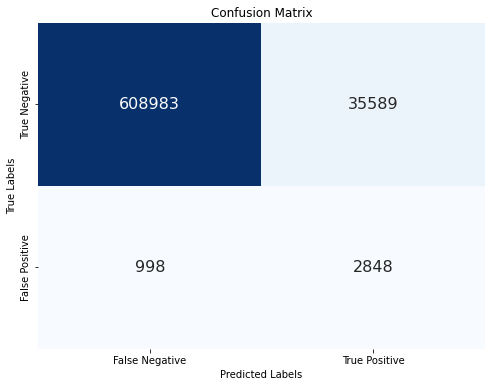

In [21]:
# Create and show the confusion matrix
confusion_matrix_df = lr_predictions.groupBy("is_fraud", "prediction").count()

# Convert Spark DataFrame to Pandas DataFrame for confusion matrix
predictions_and_labels = lr_predictions.select(col("prediction"), col("is_fraud")).rdd
prediction_df = predictions_and_labels.toDF(["prediction", "label"]).toPandas()

# Compute confusion matrix
conf_matrix = sk_confusion_matrix(prediction_df["label"], prediction_df["prediction"])

# Create a DataFrame for visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=["True Negative", "False Positive"], columns=["False Negative", "True Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("confusion_matrix_plot.png")  # Save the plot as an image file
plt.show()

# Save Files

In [22]:
# Convert confusion matrix DataFrame to a Spark DataFrame
conf_matrix_spark_df = spark.createDataFrame(conf_matrix_df.reset_index())
# Save confusion matrix to CSV in a single partition
conf_matrix_spark_df.repartition(1).write.option("header", "true").mode("overwrite").csv("hdfs:///user/student/transactions_new/confusion_matrix.csv")

# Save evaluation metrics to CSV in a single partition (HDFS)
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Fraud Class)", "Recall (Fraud Class)", "F1 Score", "ROC-AUC"],
    "Value": [accuracy, precision, recall, f1_score, roc_auc]
})

# Convert metrics DataFrame to Spark DataFrame
metrics_spark_df = spark.createDataFrame(metrics_df)

# Save evaluation metrics to CSV in a single partition
metrics_spark_df.repartition(1).write.option("header", "true").mode("overwrite").csv("hdfs:///user/student/transactions_new/metrics.csv")